In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rk_4_imp as rk4

from scipy.integrate import odeint,ode

hbar,m_e,e = 1,1,1

%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['mathtext.rm'] = 'dejavuserif'
plt.rcParams['mathtext.it'] = 'dejavuserif'
plt.rcParams['mathtext.bf'] = 'dejavuserif'

In [2]:
def coup(n,m):
    s1 = np.sin((n + m) * np.pi/2)/(n + m)**2
    s2 = np.sin((n - m) * np.pi/2)/(n - m)**2
    return s1 - s2
    
def x_nm(n,m,L):
    return 2 * L * coup(n,m) / np.pi**2

def E_n(n,L):
    return np.pi**2 * n**2 / (2 * L**2)

def omega_nm(n,m,L):
    return E_n(n,L) - E_n(m,L)

# ******************************************** #

def alpha(q,E0,x_nm):
    return -q * E0 * x_nm

def R_Omega(det,alpha):
    return np.sqrt(det**2 + alpha**2)

In [3]:
# RWA transition probabilities

def prob_1(t,det,alpha_nm):
    p1_1 = np.cos(R_Omega(det,alpha_nm)*t/2)**2
    p1_2 = np.sin(R_Omega(det,alpha_nm)*t/2)**2 * det**2 / R_Omega(det,alpha_nm)**2
    
    return p1_1 + p1_2

def prob_2(t,det,alpha_nm):
    
    return np.sin(R_Omega(det,alpha_nm)*t/2)**2 * alpha_nm**2 / R_Omega(det,alpha_nm)**2

In [4]:
# noRWA coeff diff eq

def c1_dot(t,c2,omega_0,omega_E,alpha):
    return c2 * np.exp(-1j * omega_0 * t) * np.cos(omega_E * t) * alpha / 1j

def c2_dot(t,c1,omega_0,omega_E,alpha):
    return c1 * np.exp(1j * omega_0 * t) * np.cos(omega_E * t) * alpha / 1j

def ode_syst(t,y,params):
    c1,c2 = y
    omega_0,omega_E,alpha = params
    
    diffs = np.array([c1_dot(t,c2,omega_0,omega_E,alpha),c2_dot(t,c1,omega_0,omega_E,alpha)],dtype='complex_')
    
    return diffs

def noRWA_int(n1,n2,det,q,E0,L,t_lim,dt,in_cond):
    
    omega_n2n1 = omega_nm(n2,n1,L)
    x_n2n1 = x_nm(n1,n2,L)
    alpha_n2n1 = alpha(q,E0,x_n2n1)
    omega_E = omega_n2n1 + det
    
    y0,t0 = in_cond
    
    df_int = ode(ode_syst).set_integrator('zvode', method='bdf')
    df_int.set_initial_value(y0, t0).set_f_params([omega_n2n1,omega_E,alpha_n2n1])
    
    sol = []
    
    while df_int.successful() and df_int.t < t_lim:
        sol.append([df_int.t+dt, df_int.integrate(df_int.t+dt)])
        
    return sol

def noRWA_rk4(n1,n2,det,q,E0,L,t_lim,dt,in_cond):
    
    omega_n2n1 = omega_nm(n2,n1,L)
    x_n2n1 = x_nm(n1,n2,L)
    alpha_n2n1 = alpha(q,E0,x_n2n1)
    omega_E = omega_n2n1 + det
    
    sols = rk4.solve_rk4(ode_syst,t_lim,dt,in_cond,omega_n2n1,omega_E,alpha_n2n1)
    
    return sol

In [5]:
# for ground and 1st exited state

q,E0,L = 1,0.1,10

x_21 = x_nm(1,2,L)

w_21 = omega_nm(2,1,L)

alpha_21 = alpha(q,E0,x_21)

w_21,alpha_21

(0.14804406601634035, -0.1801265486974894)

Text(0.5, 1.0, 'Inversión de población')

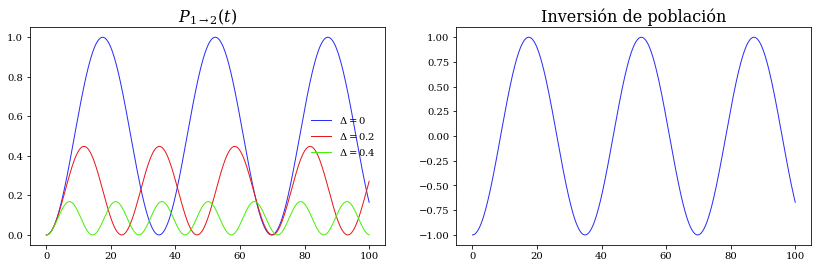

In [6]:
t = np.linspace(0,100,1000) #t scale: 2.41888e-17 s

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))

ax1.plot(t,prob_2(t,0,alpha_21),color='#2a2ef6',linewidth=1,label=r'$\Delta = 0$')
ax1.plot(t,prob_2(t,0.2,alpha_21),color='#e91717',linewidth=1,label=r'$\Delta = 0.2$')
ax1.plot(t,prob_2(t,0.4,alpha_21),color='#48ef06',linewidth=1,label=r'$\Delta = 0.4$')

ax1.set_title(r'$P_{1 \rightarrow 2}(t)$',fontsize=16)

ax1.legend(frameon=False)

ax2.plot(t,prob_2(t,0,alpha_21)-prob_1(t,0,alpha_21),color='#2a2ef6',linewidth=1)

ax2.set_title(r'Inversión de población',fontsize=16)

In [32]:
q,E0,L = 1,0.1,10
t_lim = 100
dt = 0.05
in_cond = [[1,0],0]
in_cond_rk4 = [1,0,0]

sol = noRWA_int(1,2,0,q,E0,L,t_lim,dt,in_cond)
sol_rk4 = noRWA_rk4(1,2,0,q,E0,L,t_lim,dt,in_cond_rk4)

c1 = [np.abs(c1_sol[1][0]) for c1_sol in sol]
c2 = [np.abs(c2_sol[1][1]) for c2_sol in sol]

c1_rk4 = [np.abs(c1_sol[1][0]) for c1_sol in sol_rk4]
c2_rk4 = [np.abs(c2_sol[1][1]) for c2_sol in sol_rk4]

t = [t_sol[0] for t_sol in sol_rk4]

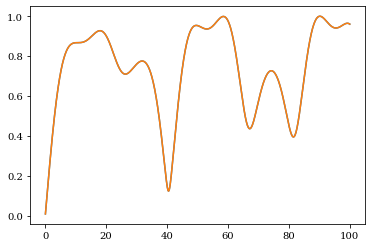

In [33]:
plt.plot(t,c2)
plt.plot(t,c2_rk4)

In [9]:
# solution separating real and imaginary parts

def a1_dot(t,y,omega_0,omega_E,alpha):
    a1,b1,a2,b2 = y
    
    a11 = np.cos(omega_E*t)*np.cos(omega_0*t)*b2
    a12 = -1.*np.cos(omega_E*t)*np.sin(omega_0*t)*a2
    
    return (a11+a12)*alpha

def b1_dot(t,y,omega_0,omega_E,alpha):
    a1,b1,a2,b2 = y
    
    b11 = -1.*np.cos(omega_E*t)*np.cos(omega_0*t)*a2
    b12 = -1.*np.cos(omega_E*t)*np.sin(omega_0*t)*b2
    
    return (b11+b12)*alpha

def a2_dot(t,y,omega_0,omega_E,alpha):
    a1,b1,a2,b2 = y
    
    a21 = np.cos(omega_E*t)*np.cos(omega_0*t)*b1
    a22 = np.cos(omega_E*t)*np.sin(omega_0*t)*a1
    
    return (a21+a22)*alpha

def b2_dot(t,y,omega_0,omega_E,alpha):
    a1,b1,a2,b2 = y
    
    b21 = -1.*np.cos(omega_E*t)*np.cos(omega_0*t)*a1
    b22 = np.cos(omega_E*t)*np.sin(omega_0*t)*b1
    
    return (b21+b22)*alpha

def ode_syst_reim(t,y,params):
    omega_0,omega_E,alpha = params
    
    a1_d = a1_dot(t,y,omega_0,omega_E,alpha)
    b1_d = b1_dot(t,y,omega_0,omega_E,alpha)
    a2_d = a2_dot(t,y,omega_0,omega_E,alpha)
    b2_d = b2_dot(t,y,omega_0,omega_E,alpha)
    
    diffs = np.array([a1_d,b1_d,a2_d,b2_d])
    
    return diffs


def noRWA_rk4_reim(n1,n2,det,q,E0,L,t_lim,dt,y0):
    
    omega_n2n1 = omega_nm(n2,n1,L)
    x_n2n1 = x_nm(n1,n2,L)
    alpha_n2n1 = alpha(q,E0,x_n2n1)
    omega_E = omega_n2n1 + det
    
    sols = rk4.solve_rk4(ode_syst_reim,t_lim,dt,y0,omega_n2n1,omega_E,alpha_n2n1)
    
    return sols

In [46]:
q,E0,L = 1,0.1,10
t_lim = 100
dt = 0.05
in_cond_reim = [1,0,0,0,0]

sol_rk4_reim = noRWA_rk4_reim(1,2,0,q,E0,L,t_lim,dt,in_cond_reim)

In [47]:
c1_reim = [a1[0][0]**2 + b1[1][0]**2 for a1,b1 in zip(sol_rk4_reim,sol_rk4_reim)]
c2_reim = [a2[2][0]**2 + b2[3][0]**2 for a2,b2 in zip(sol_rk4_reim,sol_rk4_reim)]

t_reim = [t[4][0] for t in sol_rk4_reim]

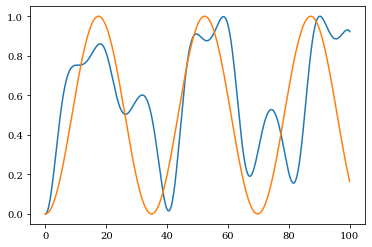

In [50]:
t = np.linspace(0,100,1000)

plt.plot(t_reim,c2_reim)
plt.plot(t,prob_2(t,0,alpha_21))